In [130]:
import numpy as np
import torch
import torch.nn.functional as F

from dataset import get_twit_company_dataloaders, get_twit_sentiment_dataloaders, \
    get_twit_company_sentiment_dataloaders, one_hot_company, one_hot_sentiment
from model import LSTMTwitClassifier

# text, label = next(iter(dataloader_train))

In [119]:
device = "cuda"
use_wandb = True

lr = 0.001
embedding_size = 100
hidden_size = 100
epochs_cnt = 100
embeddings = "random"
lstm_layers = 1
dropout = 0.8
task = "text2sentiment"  #
use_company_info = True
preprocessing = "tutorial"
use_stop_words = True
weight = [5, 3.5, 1, 1.5]  # [0.4, 0.4, 0.1, 0.1] # None

# remove x sometimes (because cool archirecture (; )
save_file = f"{epochs_cnt}epochs_{task}_{preprocessing}{f'_use_company' if use_company_info and task == 'text2sentiment' else ''}{'_'.join(map(str, weight)) + '_weight' if weight is not None else ''}"

get_dataloaders = get_twit_company_dataloaders if task == "text2company" else
    get_twit_sentiment_dataloaders if not use_company_info else get_twit_company_sentiment_dataloaders

dataset_train, dataloader_train, dataset_test, dataloader_test = get_dataloaders(embedding_dim=embedding_size,
                                                                                 embedding=embeddings,
                                                                                 preprocessing=preprocessing,
                                                                                 use_stop_words=use_stop_words)

model = LSTMTwitClassifier(4, embedding_dim=embedding_size, hidden_dim=hidden_size, dropout=dropout,
                           lstm_layers=lstm_layers,
                           additional_one_hot_arg=use_company_info and task == "text2sentiment")
model.to(device)

model.load_state_dict(torch.load(f"learned_models/{save_file}_best_test.pt"))
model.eval()

print("Testing on test loading model")

correct = 0
predictions_cnt = [0, 0, 0, 0]
correct_cnt = [0, 0, 0, 0]

matrix = np.zeros([4, 4])

with torch.no_grad():
    for i, (*args, target) in enumerate(dataloader_test):
        args = [arg.to(device) for arg in args]
        target = target.to(device)

        prediction = model(*args)
        prediction = F.softmax(prediction, dim=0)

        if torch.argmax(prediction) == torch.argmax(target):
            correct += 1

        predictions_cnt[torch.argmax(prediction)] += 1
        correct_cnt[torch.argmax(target)] += 1
        matrix[torch.argmax(prediction)][torch.argmax(target)] += 1

        if i % 100 == 0:
            print(f"Iter: {i}/{len(dataloader_test)}")

print(f"Accuracy {correct / len(dataloader_test)}")

Tweet ignored due to unreadability: Поиск от 
Tweet ignored due to unreadability: Новите 
Tweet ignored due to unreadability: 看見 
Tweet ignored due to unreadability: نظام جديد .. و جهاز جديد شكراً جزيلاً 
Tweet ignored due to unreadability: الجهاز الجديد عجيب   
Tweet ignored due to unreadability: يبدو ان طفرة الاجهزة الالكترونية القادمة ستكون بقيادة موتورولا ،، لاسيم بعد استحواذ قوقل عليها.   
Tweet ignored due to unreadability: Με συγχισες 
Tweet ignored due to unreadability: На сайте 
Tweet ignored due to unreadability: Настоящий твиттерянин как только попадает в толпу стремиться тут же как можно быстрее попасть в 
Tweet ignored due to unreadability: Доброе утро 
Tweet ignored due to unreadability: 【
Tweet ignored due to unreadability: رقم الفلو والفلورز والتويتات  للبيع لاعلى سعر 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ars86\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tweet ignored due to unreadability: قال الرئيس التنفيذي لشركة 
Tweet ignored due to unreadability: Улучшим продукты компании 
Tweet ignored due to unreadability: نفسي يوم يعدي علي تويتر من غير مشاكل فنية 
Tweet ignored due to unreadability: ツイッター検索 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ars86\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Testing on test loading model
Iter: 0/332
Iter: 100/332
Iter: 200/332
Iter: 300/332
Accuracy 0.7168674698795181


positive: precision=0.6, recall=0.5806451612903226
negative: precision=0.75, recall=0.30612244897959184
neutral: precision=0.6972972972972973, recall=0.8486842105263158
irrelevant: precision=0.7835051546391752, recall=0.76


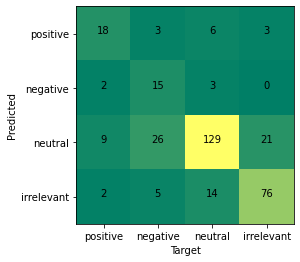

In [120]:
import itertools
from matplotlib import pyplot as plt

companies = ['apple', 'google', 'microsoft', 'twitter']
sentiments = ['positive', 'negative', 'neutral', 'irrelevant']

labels = sentiments if task == "text2sentiment" else companies

for i, label in enumerate(labels):
    precision = matrix[i][i] / matrix.sum(1)[i]
    recall = matrix[i][i] / matrix.sum(0)[i]
    print(f"{label}: precision={precision}, recall={recall}")


def plot_matrix(matrix):
    plt.imshow(matrix, interpolation='nearest', cmap='summer')
    h, w = matrix.shape
    for i, j in itertools.product(range(h), range(w)):
        plt.text(j, i, format(matrix[i, j], '.0f'),
                 horizontalalignment="center",
                 color="black")

    plt.xticks(np.arange(len(labels)), labels)
    plt.yticks(np.arange(len(labels)), labels)
    plt.xlabel('Target')
    plt.ylabel('Predicted')
    plt.show()


plot_matrix(matrix)

In [131]:
one_hot = one_hot_company if task == "text2company" else one_hot_sentiment

def predict(sentence, something=None):
    sentence = dataset_test.process(sentence).to(device)
    something = one_hot_company(something)
    if task == "text2company" or not use_company_info:
        something = None

    model.eval()
    with torch.no_grad():
        prediction = model(sentence, torch.Tensor(something).to(device))
        prediction = F.softmax(prediction, dim=0)
        return labels[torch.argmax(prediction)], torch.max(prediction).cpu().item()

In [145]:
predict("iphone is bad", "apple")

('negative', 0.7547683119773865)

In [143]:
predict("I love microsоft ❤️", "microsoft")

('positive', 0.9478293061256409)